In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

from accident_risk.config import RAW_TRAIN_PATH

In [2]:
data = pd.read_csv("../" + RAW_TRAIN_PATH)

In [3]:
train, validation = train_test_split(data, shuffle=False)

In [4]:
print("Train len: ", len(train))
print("Validation len: ", len(validation))


Train len:  388315
Validation len:  129439


# EDA

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 388315 entries, 0 to 388314
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      388315 non-null  int64  
 1   road_type               388315 non-null  object 
 2   num_lanes               388315 non-null  int64  
 3   curvature               388315 non-null  float64
 4   speed_limit             388315 non-null  int64  
 5   lighting                388315 non-null  object 
 6   weather                 388315 non-null  object 
 7   road_signs_present      388315 non-null  bool   
 8   public_road             388315 non-null  bool   
 9   time_of_day             388315 non-null  object 
 10  holiday                 388315 non-null  bool   
 11  school_season           388315 non-null  bool   
 12  num_reported_accidents  388315 non-null  int64  
 13  accident_risk           388315 non-null  float64
dtypes: bool(4), float64(2), i

## Single variable exploration

<Axes: xlabel='road_type'>

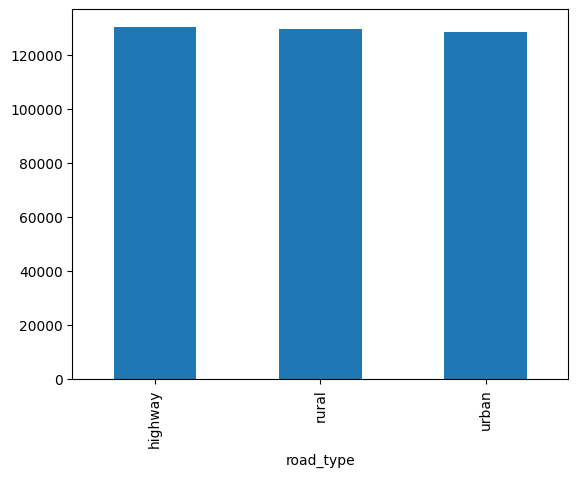

In [6]:
# categorical variable
train["road_type"].value_counts().plot.bar()

<Axes: xlabel='num_lanes'>

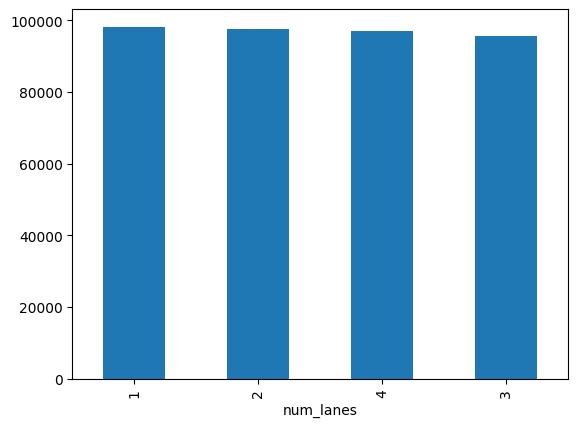

In [7]:
# ordinal variable
train["num_lanes"].value_counts().plot.bar()

In [8]:
# continuous, values in [0, 1]
train["curvature"].describe()

count    388315.000000
mean          0.488708
std           0.272696
min           0.000000
25%           0.260000
50%           0.510000
75%           0.710000
max           1.000000
Name: curvature, dtype: float64

<Axes: ylabel='Density'>

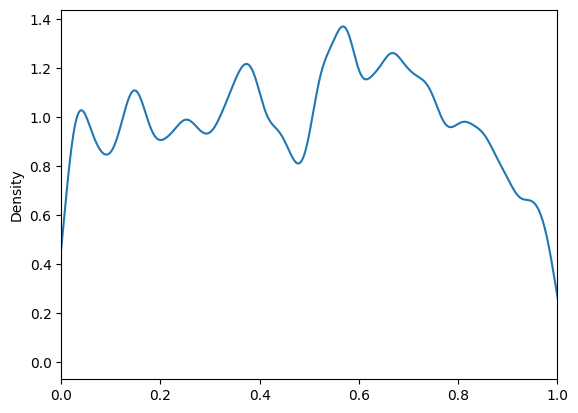

In [9]:
data["curvature"].plot.kde(xlim=(0, 1))


<Axes: xlabel='speed_limit'>

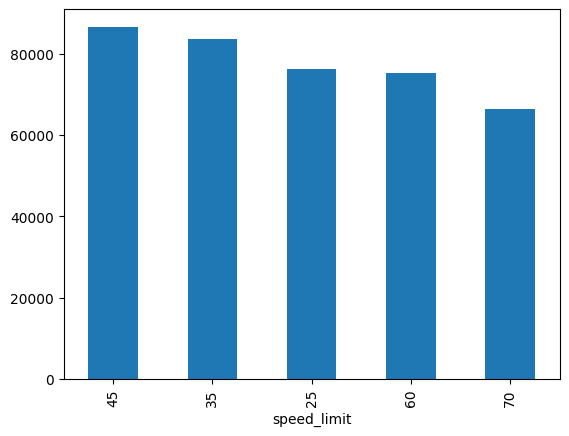

In [10]:
# discrete, few (5) distinct values
train["speed_limit"].value_counts().plot.bar()

<Axes: xlabel='lighting'>

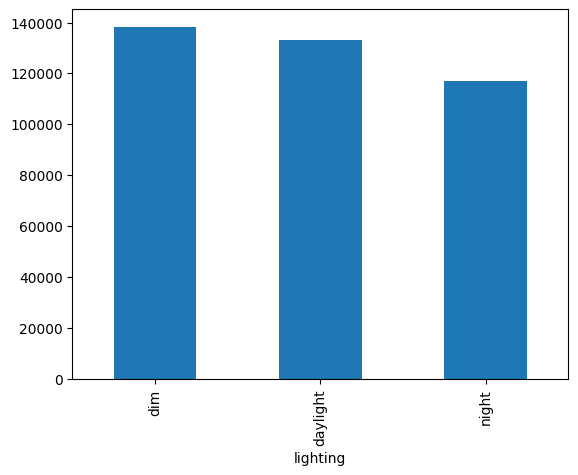

In [11]:
# categorical
train["lighting"].value_counts().plot.bar()

<Axes: xlabel='weather'>

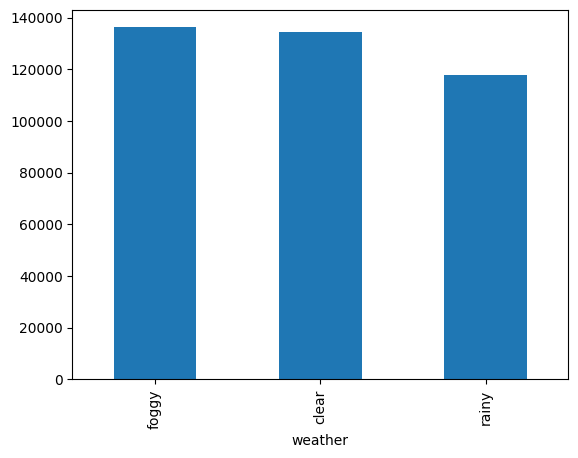

In [12]:
# categorical
train["weather"].value_counts().plot.bar()

<Axes: xlabel='road_signs_present'>

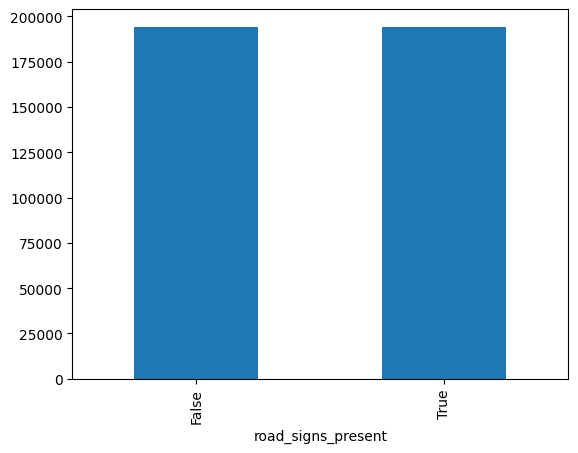

In [13]:
# binary
train["road_signs_present"].value_counts().plot.bar()


<Axes: xlabel='public_road'>

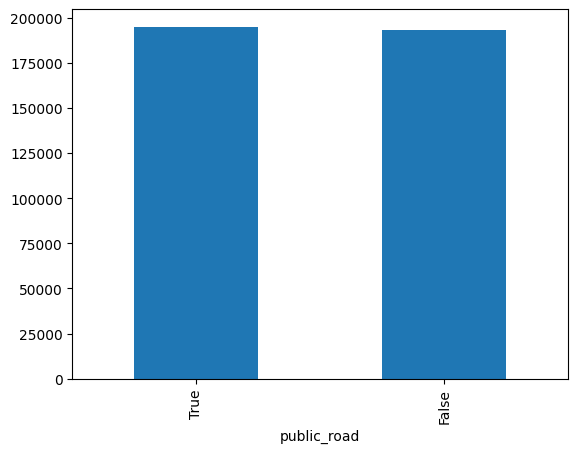

In [14]:
# binary
train["public_road"].value_counts().plot.bar()


<Axes: xlabel='time_of_day'>

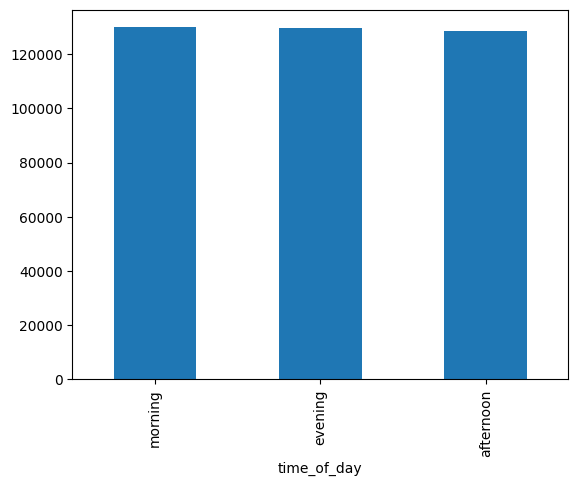

In [15]:
# categorical
train["time_of_day"].value_counts().plot.bar()

<Axes: xlabel='holiday'>

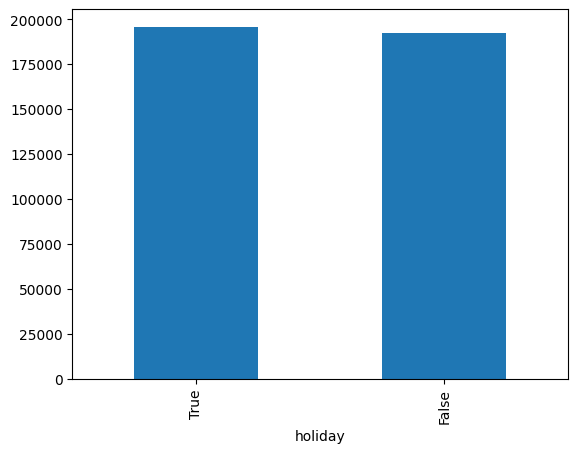

In [16]:
# binary
train["holiday"].value_counts().plot.bar()

<Axes: xlabel='school_season'>

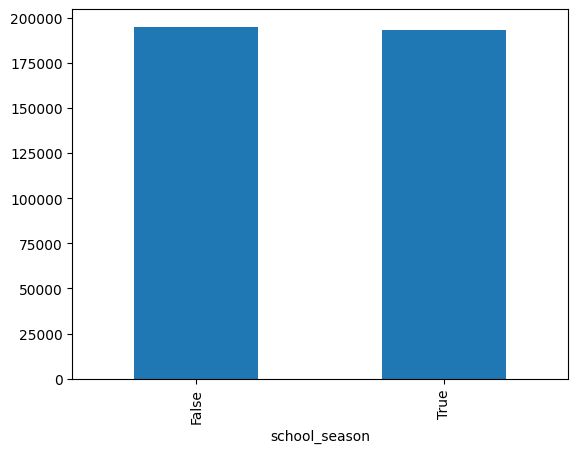

In [17]:
# binary
train["school_season"].value_counts().plot.bar()

<Axes: >

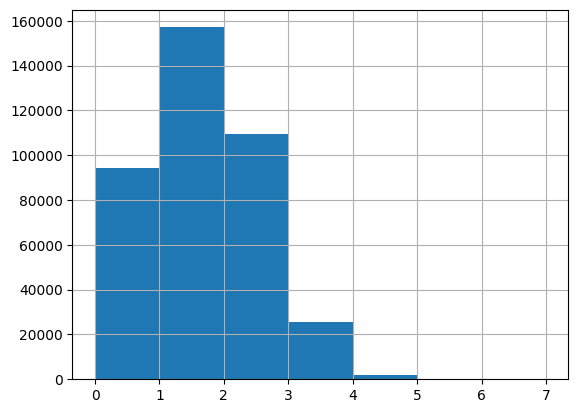

In [18]:
# counts/discrete, few distinct values (8)
train["num_reported_accidents"].hist(bins=7)

In [19]:
train["num_reported_accidents"].value_counts()

num_reported_accidents
1    157123
2    109384
0     94172
3     25621
4      1809
5       185
6        19
7         2
Name: count, dtype: int64

In [20]:
# target variable, accident risk probability [0, 1]
train["accident_risk"].describe()

count    388315.000000
mean          0.352426
std           0.166328
min           0.000000
25%           0.230000
50%           0.340000
75%           0.460000
max           1.000000
Name: accident_risk, dtype: float64

<Axes: ylabel='Density'>

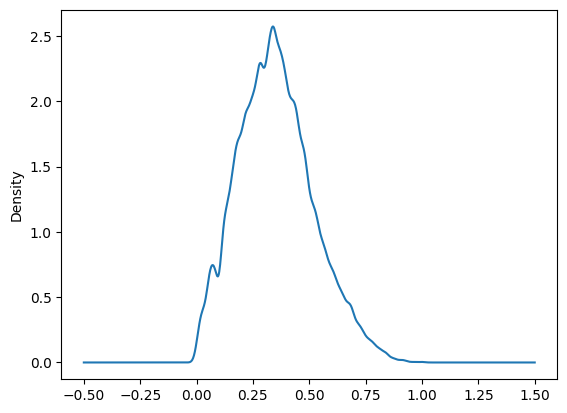

In [21]:
# looks normally distributed
train["accident_risk"].plot.kde()

In [22]:
from scipy.stats import normaltest

stat, p = normaltest(train["accident_risk"])

# if p-value < 0.05, we reject the null hypothesis that the data is normally distributed
print(f'Stat={stat:.3f}, p={p:.3f}')

Stat=8815.703, p=0.000


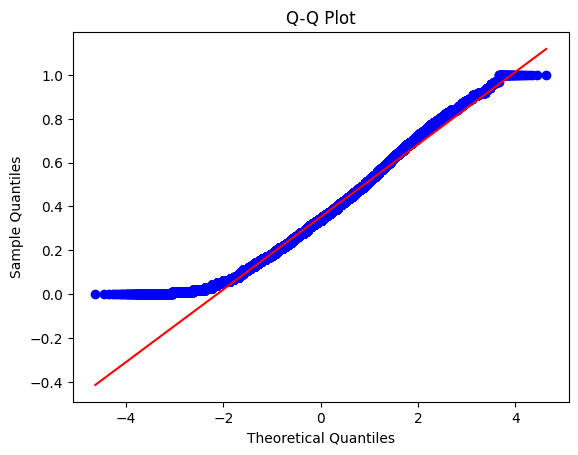

In [23]:
# double-check with a QQ plot, 
# since for large data - even small deviations may cause a false rejection
import scipy.stats as st
import matplotlib.pyplot as plt

st.probplot(train["accident_risk"], dist="norm", plot=plt)

# Add labels and title
plt.title("Q-Q Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

# roughly normal, but bounded at the tails
# makes sense since data is in [0, 1]
# a logit transformation might be useful

In [24]:
import numpy as np

epsilon = 1e-6
target = train["accident_risk"].values

target = np.clip(target, epsilon, 1 - epsilon)

target = np.log(target / (1 - target))

In [25]:
stat, p = normaltest(target)

# if p-value < 0.05, we reject the null hypothesis that the data is normally distributed
print(f'Stat={stat:.3f}, p={p:.3f}')

Stat=265124.928, p=0.000


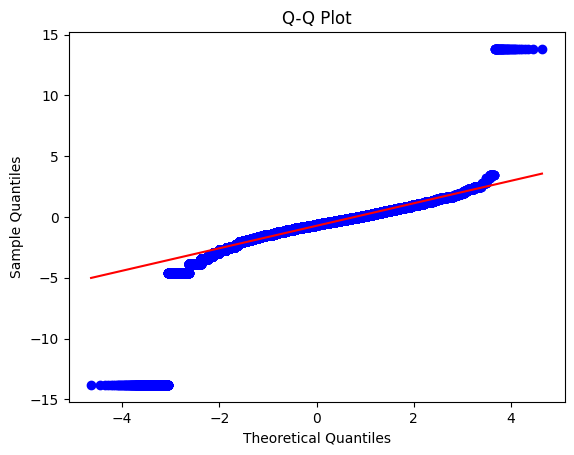

In [26]:
st.probplot(target, dist="norm", plot=plt)

# Add labels and title
plt.title("Q-Q Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

# tails are not normally distributed
# takeaway: be careful with models that are sensitive to extreme values

## Explore pairwise correlations 

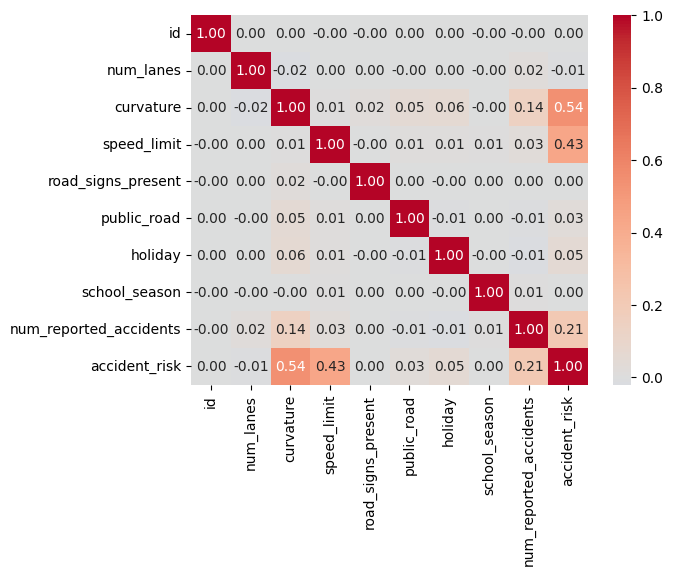

In [27]:
# curvature, speed limit, and number of reported accidents seem to be correlated with accident risk
# there is also some correlation between curvature and the number of reported accidents
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap="coolwarm", center=0, fmt=".2f",)  # annot=True shows values
plt.show()